In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import numpy as np
from numpy import loadtxt
import tensorflow as tf

f = h5py.File('mouse1sample1.hdf5','r')

In [2]:
annotated_cells = []
annotations = []
for cell_id in f['cells']:
    cell = f['cells'][cell_id]
    ann = dict(cell.attrs)['annotation']
    if ann != 'unannotated':
        annotated_cells.append(cell_id)
        annotations.append(ann)

Number of Annotated Samples: 18453
Num of Cell Types: 93
Max Number of Samples per Cell Type: 2136
Min Number of Samples per Cell Type: 1
Average Number of Samples per Cell Type: 198.41935483870967


<BarContainer object of 93 artists>

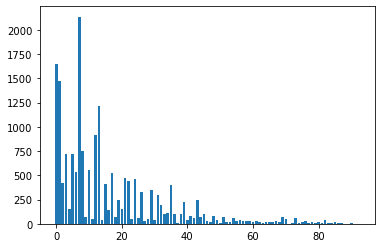

In [3]:
annotations_count = Counter(annotations)
print("Number of Annotated Samples:", len(annotated_cells))
print("Num of Cell Types:", len(annotations_count))
print("Max Number of Samples per Cell Type:", max(annotations_count.values()))
print("Min Number of Samples per Cell Type:", min(annotations_count.values()))
print("Average Number of Samples per Cell Type:", sum(annotations_count.values())/93)

#graph of num of samples across cell-types 
plt.bar(np.arange(0,93), annotations_count.values())

In [4]:
# # creating gene expression table -- time intensive computation
# df = pd.DataFrame()
# for cell_id in annotated_cells:
#     cell = f['cells'][cell_id]
#     gene_counts = []
#     for z in cell.attrs['zslices']: # for each z-slice corresponding to cell
#         spot_genes = cell['spot_genes'][z] # get spot_genes
#         for gene in spot_genes: # iterate over spot_genes 
#             gene_counts.append(gene.decode())
#     gene_counts = dict(Counter(gene_counts)) # get count of all genes for cell
#     df = df.append(gene_counts, ignore_index=True) # add row to pd dataframe
# df = df.fillna(0)
# df.to_csv('geneExpression.csv', sep='\t') 

In [5]:
# creating one-hot coded vectors for cell-type (labels for multi)
annotation_indices = {k: v for v, k in enumerate(list(annotations_count.keys()))}
labels = np.zeros((len(annotated_cells), len(annotation_indices)))
for index in range(0, len(annotated_cells)):
    cell = f['cells'][annotated_cells[index]]
    ann = dict(cell.attrs)['annotation']
    arr_index = annotation_indices[ann]
    labels[index][arr_index] = 1

In [6]:
dataset = loadtxt('geneExpression.csv', delimiter=',')
print(dataset.shape)

(18453, 252)


In [7]:
# normalize + scale gene expression data + remove outliers (code from ACTINN paper)
total_set = np.divide(dataset, np.sum(dataset, axis=0, keepdims=True)) * 10000
total_set = np.log2(total_set+1)
expr = np.sum(total_set, axis=1)
total_set = total_set[np.logical_and(expr >= np.percentile(expr, 1), expr <= np.percentile(expr, 99)),]
total_labels = labels[np.logical_and(expr >= np.percentile(expr, 1), expr <= np.percentile(expr, 99)),]
cv = np.std(total_set, axis=1) / np.mean(total_set, axis=1)
total_set = total_set[np.logical_and(cv >= np.percentile(cv, 1), cv <= np.percentile(cv, 99)),]
total_labels = total_labels[np.logical_and(cv >= np.percentile(cv, 1), cv <= np.percentile(cv, 99)),]

dataset=total_set

In [8]:
from sklearn.model_selection import train_test_split
train, test, train_y, test_y = train_test_split(dataset, total_labels, test_size=0.3)

test, val, test_y, val_y = train_test_split(test, test_y, test_size=0.5)
print(train.shape, train_y.shape)
print(val.shape, val_y.shape)
print(test.shape, test_y.shape)

(12404, 252) (12404, 93)
(2659, 252) (2659, 93)
(2658, 252) (2658, 93)


In [9]:
# followed model parameters + layers according to ACTINN paper 
model = tf.keras.models.Sequential([tf.keras.layers.Input(252),
                                    tf.keras.layers.Dense(100, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(50, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(25, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(93, activation=tf.nn.softmax)])
lr= tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)
model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
model.summary()
model.fit(train, train_y, batch_size=128, epochs=50, validation_data=(val, val_y))

2021-11-05 23:22:41.174593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 23:22:41.190096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 23:22:41.190490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 23:22:41.191419: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               25300     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 93)                2418      
Total params: 34,043
Trainable params: 34,043
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
97/97 [==============================] - 1s 6ms/step - loss: 4.5007 - accuracy: 0.0242 - val_loss: 4.3599 - val_accuracy: 0.0470
Epoch 2/50
97/97 [==============================] - 0s 4ms/step - loss: 4.1619 - accuracy: 0.1250 - val_loss: 

In [10]:
model.evaluate(test, test_y)

84/84 [==============================] - 0s 3ms/step - loss: 0.5496 - accuracy: 0.8382


[0.549612820148468, 0.8382242321968079]

In [11]:
y_pred = model.predict(test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(test_y, axis=1)

In [12]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y, y_pred)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets